<a href="https://colab.research.google.com/github/Harm1995/CTA-sensitivity/blob/master/Likelihood_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The packages

In [0]:
try:
  import iminuit
  from iminuit import Minuit

except:
  !pip install iminuit

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random
import scipy
from scipy.stats import norm
import astropy
from astropy.io import fits
import seaborn as sns
import time




time = 1

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
roi = 5
TeV = 10**-6
energy_start_bin = 3
offset = 0
pre_normalisation = 1
energy_bin = 0

In [0]:
TeV = 10**-6
ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"
energy_list1 = np.array(fits.getdata(ring_path + 'ics_ring_1.fits', ext=1))
energies = []
for energy in energy_list1:
    E = float(str(energy)[1:-2])
    energies.append(E)
energies = np.array(energies)
energies = energies * TeV   


# Data

## The raw data

### Original model

In [0]:
pre_path = "/content/drive/My Drive/Colab Notebooks/master_project/"
ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"


### Here we get the diffusive emission maps:
### Here we get the diffusive emission maps:
ics_ring_maps = []
GCE_ring_maps = []
signal_ring_maps = []
for i in range(1,5):
  ics = np.roll(fits.getdata(ring_path + 'ics_ring_'+str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  brems = np.roll(fits.getdata(ring_path + 'bremss_ring_'+ str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  pion = np.roll(fits.getdata(ring_path + 'pion_ring_'+ str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  signal = np.roll(fits.getdata(ring_path + 'signal_ring_'+ str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  ics_ring_maps.append(ics)
  GCE_ring_maps.append(brems + pion)
  signal_ring_maps.append(signal)

GDE_maps = []
GDE_maps.append(ics_ring_maps)
GDE_maps.append(GCE_ring_maps)
GDE_maps = np.array(GDE_maps)

signal = signal_ring_maps[0] + signal_ring_maps[1]+ signal_ring_maps[2]+ signal_ring_maps[3]
signal = np.array(signal)

fermi_map = fits.getdata(pre_path + 'fig12_bubbles_template_3compSCA_40x40deg_inpaint.fits')
sns.set()

norm = np.sum(fermi_map) * (np.pi/180.0)**2.0 * (0.5**2.0)
fermi_map = fermi_map[(40 - 2*roi):(40 + 2 * roi),
                      (40 - 2*roi):(40 + 2 * roi)] / norm
                        



In [0]:
def fermi_function(E):
  phi0 = 1 * 10**-8
  sigma = 1.9
  E_co = 20

  fluxq = phi0 * np.exp(-E/E_co) * E**-sigma
  return fluxq

fermi_flux = []

for E in energies:
  fermi_flux.append(fermi_function(E) * E**2 )

fermi_flux = np.array(fermi_flux)


### Alternative model

In [0]:
pre_path_alt = '/content/drive/My Drive/Colab Notebooks/master_project/Alternative_GDE/'

dust_pos =fits.getdata(pre_path_alt + 'DustPositive_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
dust_neg =fits.getdata(pre_path_alt + 'DustNegative_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]

dust_neg = np.array(dust_neg)
dust_pos = np.array(dust_pos)



H1_maps = []
H2_maps = []
for ring in range(1,5):
  map_H2 = fits.getdata(pre_path_alt + f'H2_pohl_ring_{ring}_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
  map_H1 = fits.getdata(pre_path_alt + f'HI_pohl_T150K_ring_{ring}_Normalized.fits')[(180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  H1_maps.append(map_H1)
  H2_maps.append(map_H2)


initial_norm_factor = (np.sum(H1_maps) + np.sum(H2_maps) + np.sum(dust_neg + dust_pos) ) / np.sum(GCE_ring_maps) 


H1_norm = []
H2_norm = []
dust_pos_norm = dust_pos / initial_norm_factor
dust_neg_norm = dust_neg / initial_norm_factor

for i in range(0,4):
  H1_norm.append(H1_maps[i] / initial_norm_factor )
  H2_norm.append(H1_maps[i] / initial_norm_factor )



### Signal maps

In [0]:
path_to_signal = '/content/drive/My Drive/Colab Notebooks/data_txt_files/NB_and_F98/'
NB_ring_maps = []
F98_ring_maps = []
injections = ['inj0','inj1', 'inj2', 'inj3', 'inj4']
for inj in injections:
  temp_map = []
  temp_map2 = []
  for ring in range(1,5):
    NB_map = np.roll(fits.getdata(path_to_signal + 'NB_ring_'+ str(ring) +'_' + inj + '.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
    F98_map = np.roll(fits.getdata(path_to_signal + 'NB_ring_'+ str(ring) +'_' + inj +  '.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
    temp_map.append(NB_map)
    temp_map2.append(F98_map)
  tot1 = temp_map[0] + temp_map[1] + temp_map[2] + temp_map[3]
  tot2 = temp_map2[0] + temp_map2[1] + temp_map2[2] + temp_map2[3]
  NB_ring_maps.append(tot1)
  F98_ring_maps.append(tot2)

NB_ring_maps = np.array(NB_ring_maps)
F98_ring_maps = np.array(F98_ring_maps)

sigals = [NB_ring_maps[0] + F98_ring_maps[0], NB_ring_maps[1] + F98_ring_maps[1], NB_ring_maps[2] + F98_ring_maps[2], NB_ring_maps[3] + F98_ring_maps[3],NB_ring_maps[4] + F98_ring_maps[4]]


In [0]:
print (np.sum(NB_ring_maps))
print (np.sum(F98_ring_maps))

1.0920271e-08
1.0920271e-08


We have the following Background flux maps

* 4 rings of ics maps 47 * 20 * 20
* 4 rings of GCE maps 47 * 20 * 20
* 1 Fermi map 20*20


And for the alternative model:

* 4 ring maps H1 40*40
* 4 ring maps H2 40*40
* 2 dust maps 20*20

And the Following signal - maps:

* 5  injection spectra NB signal map 47 * 20 * 20
* 5  injection spectra F98 map 47 * 20 * 20

## Convolved data

In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'

orig_shape = (9, 47, 20, 20)
original_file = files_paths + 'Model_new.txt.txt'
simulated_backgrounds = np.loadtxt(original_file).reshape(orig_shape)

ice_rings = np.loadtxt(files_paths + 'ice_file.txt').reshape(4,46,20,20)
gce_rings = np.loadtxt(files_paths + 'gce_file.txt').reshape(4,46,20,20)
NB_rings = np.loadtxt(files_paths + 'NB_file.txt').reshape(5,46,20,20)
F98_rings = np.loadtxt(files_paths + 'F98_file.txt').reshape(5,46,20,20)
alternative_gce = np.loadtxt(files_paths + 'Alternative_gce.txt').reshape(10,46,20,20)
fermi_bubble = simulated_backgrounds[-1][:-1] * 137


signal_inj_list = NB_rings + F98_rings
all_backgrounds = np.array([ice_rings[0], ice_rings[1], ice_rings[2], ice_rings[3], gce_rings[0], gce_rings[1], gce_rings[2], gce_rings[3],fermi_bubble])

We have the following Background Count maps

* 4 rings of ics maps 46 * 20 * 20
* 4 rings of GCE maps 46 * 20 * 20
* 1 Fermi map 46 * 20 * 20


And for the alternative model:


* 4 ring maps H1 46 * 40 * 40
* 4 ring maps H2 46 * 40 * 40
* 4 rings of ics 46 * 20 * 20
* 2 dust maps 46 * 20 * 20
* 1 Fermi map 46 * 20 * 20

And the Following signal - maps:

* 5  injection spectra NB signal map 46 * 20 * 20
* 5  injection spectra F98 map 46 * 20 * 20

## Compressing again to 11 rings

In [0]:
Ics_ring_1_template = []
Ics_ring_2_template = []
Ics_ring_3_template = []
Ics_ring_4_template = []
GCE_ring_1_template = []
GCE_ring_2_template = []
GCE_ring_3_template = []
GCE_ring_4_template = []

fermi_template = []

NB_0_template = []
NB_1_template = []
NB_2_template = []
NB_3_template = []
NB_4_template = []

F98_0_template = []
F98_1_template = []
F98_2_template = []
F98_3_template = []
F98_4_template = []

H1_ring_1_template = []
H1_ring_2_template = []
H1_ring_3_template = []
H1_ring_4_template = []

H2_ring_1_template = []
H2_ring_2_template = []
H2_ring_3_template = []
H2_ring_4_template = []

dust_pos_template = []
dust_neg_template = []


new_energies = []

for j in range(0,11):
  i = 2+j*4
  new_energies.append(energies[i])


  Ics_ring_1_template.append(np.sum(ice_rings[0][i:i+4], axis = 0))
  Ics_ring_2_template.append(np.sum(ice_rings[1][i:i+4], axis = 0))
  Ics_ring_3_template.append(np.sum(ice_rings[2][i:i+4], axis = 0))
  Ics_ring_4_template.append(np.sum(ice_rings[3][i:i+4], axis = 0))

  GCE_ring_1_template.append(np.sum(gce_rings[0][i:i+4], axis = 0))
  GCE_ring_2_template.append(np.sum(gce_rings[1][i:i+4], axis = 0))
  GCE_ring_3_template.append(np.sum(gce_rings[2][i:i+4], axis = 0))
  GCE_ring_4_template.append(np.sum(gce_rings[3][i:i+4], axis = 0))

  fermi_template.append(np.sum(fermi_bubble[i:i+4], axis = 0))

  NB_0_template.append(np.sum(NB_rings[0][i:i+4], axis = 0))
  NB_1_template.append(np.sum(NB_rings[1][i:i+4], axis = 0))
  NB_2_template.append(np.sum(NB_rings[2][i:i+4], axis = 0))
  NB_3_template.append(np.sum(NB_rings[3][i:i+4], axis = 0))
  NB_4_template.append(np.sum(NB_rings[4][i:i+4], axis = 0))

  F98_0_template.append(np.sum(F98_rings[0][i:i+4], axis = 0))
  F98_1_template.append(np.sum(F98_rings[1][i:i+4], axis = 0))
  F98_2_template.append(np.sum(F98_rings[2][i:i+4], axis = 0))
  F98_3_template.append(np.sum(F98_rings[3][i:i+4], axis = 0))
  F98_4_template.append(np.sum(F98_rings[4][i:i+4], axis = 0))

  H1_ring_1_template.append(np.sum(alternative_gce[0][i:i+4], axis = 0))
  H1_ring_2_template.append(np.sum(alternative_gce[1][i:i+4], axis = 0))
  H1_ring_3_template.append(np.sum(alternative_gce[2][i:i+4], axis = 0))
  H1_ring_4_template.append(np.sum(alternative_gce[3][i:i+4], axis = 0))

  H2_ring_1_template.append(np.sum(alternative_gce[4][i:i+4], axis = 0))
  H2_ring_2_template.append(np.sum(alternative_gce[5][i:i+4], axis = 0))
  H2_ring_3_template.append(np.sum(alternative_gce[6][i:i+4], axis = 0))
  H2_ring_4_template.append(np.sum(alternative_gce[7][i:i+4], axis = 0))

  dust_pos_template.append(np.sum(alternative_gce[8][i:i+4], axis = 0))
  dust_neg_template.append(np.sum(alternative_gce[9][i:i+4], axis = 0))



Ics_ring_1_template = np.array(Ics_ring_1_template)
Ics_ring_2_template = np.array(Ics_ring_2_template)
Ics_ring_3_template = np.array(Ics_ring_3_template)
Ics_ring_4_template = np.array(Ics_ring_4_template)
GCE_ring_1_template = np.array(GCE_ring_1_template)
GCE_ring_2_template = np.array(GCE_ring_2_template)
GCE_ring_3_template = np.array(GCE_ring_3_template)
GCE_ring_4_template = np.array(GCE_ring_4_template)

fermi_template = np.array(fermi_template)

NB_0_template = np.array(NB_0_template)
NB_1_template = np.array(NB_1_template)
NB_2_template = np.array(NB_2_template)
NB_3_template = np.array(NB_3_template)
NB_4_template = np.array(NB_4_template)

NB_templates = np.array([NB_0_template, NB_1_template, NB_2_template, NB_3_template, NB_4_template])


F98_0_template = np.array(F98_0_template)
F98_1_template = np.array(F98_1_template)
F98_2_template = np.array(F98_2_template)
F98_3_template = np.array(F98_3_template)
F98_4_template = np.array(F98_4_template)

F98_templates = np.array([F98_0_template, F98_1_template, F98_2_template, F98_3_template, F98_4_template])

H1_ring_1_template = np.array(H1_ring_1_template)
H1_ring_2_template = np.array(H1_ring_2_template)
H1_ring_3_template = np.array(H1_ring_3_template)
H1_ring_4_template = np.array(H1_ring_4_template)

H2_ring_1_template = np.array(H2_ring_1_template)
H2_ring_2_template = np.array(H2_ring_2_template)
H2_ring_3_template = np.array(H2_ring_3_template)
H2_ring_4_template = np.array(H2_ring_4_template)

dust_pos_template = np.array(dust_pos_template)
dust_neg_template = np.array(dust_neg_template)


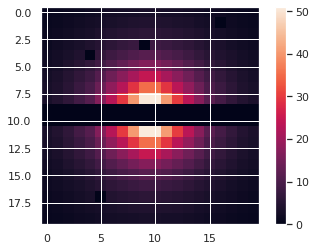

In [0]:

plt.imshow(F98_templates[2][3])
plt.colorbar()
plt.show()

# Creating the synthetic data

### The parameters we use

In [0]:
MC_times = 15
ss_steps = 10
signal_strengts = np.logspace(-2,1 ,ss_steps)
injection_spectra = 2
sigma = 0.3


### the sythentic data

In [0]:
all_backgrounds = [Ics_ring_1_template, Ics_ring_2_template, Ics_ring_3_template, Ics_ring_4_template,
                GCE_ring_1_template, GCE_ring_2_template, GCE_ring_3_template, GCE_ring_4_template, fermi_template]
signal_conv = NB_templates[injection_spectra]
all_backgrounds = np.array(all_backgrounds)



def random_counts_with_signal(signal_strength,sigma, all_backgrounds, signal_conv):
  count_matrix = np.zeros(signal_conv.shape)
  for mapn in all_backgrounds:
    after_norm = np.random.normal(1, sigma) * mapn
    after_norm = after_norm.clip(0)
    count_matrix += after_norm
  signal_norm = signal_conv * signal_strength
  count_matrix += signal_norm

  count_matrix = np.random.poisson(count_matrix)

  return count_matrix

all_simulated_background = []
for ss in signal_strengts:
  list_MC = []
  for _ in range(MC_times):
    a = random_counts_with_signal(ss,sigma, all_backgrounds, signal_conv)

    list_MC.append(a)
  all_simulated_background.append(list_MC)

all_simulated_background = np.array(all_simulated_background)
print (all_simulated_background.shape)


(10, 15, 11, 20, 20)


In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'
sim_data_file = open(files_paths + 'sim_data_file.txt', "w")


for i in np.ndindex(all_simulated_background.shape):
  np.savetxt(sim_data_file, [all_simulated_background[i]])

sim_data_file.close()  

In [0]:
data_shape = (ss_steps, MC_times, 11, 20, 20)

files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'
sim_data_file = files_paths + 'sim_data_file.txt'

simulated_backgrounds2 = np.loadtxt(sim_data_file ).reshape(data_shape)

#The bin by bin analysis class

In [0]:
class analysis:

  def __init__(self, signal_strength, model_backgrounds,signal1,signal2,data_map, long):
    self.signal_strength = signal_strength
    tot_signal = signal1 + signal2
    self.counts_m = data_map
    self.all_backgrounds = model_backgrounds
    self.signal_conv = tot_signal
    self.signal1 = signal1
    self.signal2 = signal2
    self.sigma = sigma
    self.long = long
    self.energy_bin =  energy_bin


  def L0_model_long(self, params, i,j):
    """
    The model for CTA without a signal component
    """

    tot_back = 0
    for a in range(len(self.all_backgrounds)):
      tot_back += params[a] * self.all_backgrounds[a][i][j]
    return tot_back

  def L1_model_long(self, params, i,j):
    """
    The model for CTA with a signal component
    """

    tot_back = 0
    for a in range(len(self.all_backgrounds)):
      tot_back += params[a] * self.all_backgrounds[a][i][j]  
    
    tot_back += params[-1] * self.signal1[i][j]
    
    return tot_back

  def L0_model_short(self, params, i,j,k):
    """
    The model for CTA without a signal component
    """
    tot_back = 0
    tot_back += params[0] * (self.all_backgrounds[0][i][j] + self.all_backgrounds[1][i][j] + self.all_backgrounds[2][i][j] +self.all_backgrounds[3][i][j]) 
    tot_back += params[1] * (self.all_backgrounds[4][i][j] + self.all_backgrounds[5][i][j] + self.all_backgrounds[6][i][j] +self.all_backgrounds[7][i][j]) 
    tot_back += params[2] * self.all_backgrounds[8][i][j]

    return tot_back


  def L1_model_short(self, params, i,j,k):
    """
    The model for CTA with a signal component
    """
    tot_back = 0

    tot_back += params[0] * (self.all_backgrounds[0][i][j] + self.all_backgrounds[1][i][j] + self.all_backgrounds[2][i][j] +self.all_backgrounds[3][i][j]) 
    tot_back += params[1] * (self.all_backgrounds[4][i][j] + self.all_backgrounds[5][i][j] + self.all_backgrounds[6][i][j] +self.all_backgrounds[7][i][j]) 
    tot_back += params[2] * self.all_backgrounds[8][i][j]

    tot_back += params[3] * self.signal_conv[i][j]
    return tot_back

  
  def lik0(self,params):
    """
    Function that computes the likelihood for a given set of parameters without a signal
    """
    if long:
      p_sum = 0
      for i,j in np.ndindex(self.signal_conv.shape):
        counts = self.counts_m[i][j]
        counts_model = self.L0_model_long(params, i,j)
        if counts_model > 0:  
          p = counts * np.log(counts_model) - counts_model
          p_sum += p
      return -p_sum
    else:
      p_sum = 0
      for k,i,j in np.ndindex(self.signal_conv.shape):
        counts = self.counts_m[i][j]
        counts_model = self.L0_model_short(params, i,j)
        if counts_model > 0:  
          p = counts * np.log(counts_model) - counts_model
          p_sum += p
      return -p_sum



  def lik1(self,params):
    """
    Function that computes the likelihood for a given set of parameters of the model with a signal 
    """
    if long:
      p_sum = 0
      for i,j in np.ndindex(self.signal_conv.shape):
        counts = self.counts_m[i][j]
        counts_model = self.L1_model_long(params, i,j)
        if counts_model > 0:  
          p = counts * np.log(counts_model) - counts_model
          p_sum += p
      return -p_sum
    else:
      p_sum = 0
      for i,j in np.ndindex(self.signal_conv.shape):
        counts = self.counts_m[i][j]
        counts_model = self.L1_model_short(params, i,j)
        if counts_model > 0:  
          p = counts * np.log(counts_model) - counts_model
          p_sum += p
      return -p_sum

  
  def Test_stat(self):
    if long:
      init_gues0 = []
      init_gues1 = []
      range0 = (0, 10)
      range1 = (0, 10)
      limit_list1 = []
      limit_list2 = []
      for __ in range(len(self.all_backgrounds)):
        init_gues0.append(1)
        init_gues1.append(1)
        limit_list1.append(range0)
        limit_list2.append(range1)
      limit_list2.append((0, None))
      init_gues1.append(self.signal_strength)
      m_0 = Minuit.from_array_func(self.lik0, init_gues0, error = 0.1, limit= limit_list1, errordef=0.5)
      m_1 = Minuit.from_array_func(self.lik1, init_gues1, error = 0.1, limit= limit_list2, errordef=0.5)
      c = m_0.migrad() 
      d = m_1.migrad()
      a = -m_0.fval 
      b = -m_1.fval
      T = -2*(a-b)
      return T, c,d,m_0,m_1
    else:
      init_gues0 = [1,1,1]
      init_gues1 = [1,1,1,self.signal_strength]
      range0 = (0.5, 2)
      range1 = (0.5, 2)
      m_0 = Minuit.from_array_func(self.lik0, init_gues0, error = 0.25, limit= [range0,range0,range0], errordef=0.5,)
      m_1 = Minuit.from_array_func(self.lik1, init_gues1, error = 0.25, limit= [range1,range1,range1,(0, None)], errordef=0.5)
      c = m_0.migrad() 
      d = m_1.migrad()
      a = -m_0.fval 
      b = -m_1.fval
      T = -2*(a-b)
      return T, c,d,m_0,m_1

# Doing the analysis

In [0]:
long = True

all_T = []
all_T_std = []
all_f = []
all_f_Std = []


for k in range(0,11):

  fit_values = []
  T_values = []
  energy_bin = k


  for signal_bin,ss in enumerate(signal_strengts):

    local_fit_values = []
    local_T_values = []

    for MC in range(MC_times):


      model_backgrounds = [Ics_ring_1_template[energy_bin], Ics_ring_2_template[energy_bin], Ics_ring_3_template[energy_bin], Ics_ring_4_template[energy_bin],
                      GCE_ring_1_template[energy_bin], GCE_ring_2_template[energy_bin], GCE_ring_3_template[energy_bin], GCE_ring_4_template[energy_bin], fermi_template[energy_bin]]

      model_backgrounds = np.array(model_backgrounds)
      signal1 = NB_templates[injection_spectra][energy_bin]
      signal2 = F98_templates[injection_spectra][energy_bin]
      data_map = all_simulated_background[signal_bin][MC][energy_bin]

      ss = signal_strengts[signal_bin] 

      M = analysis(ss, model_backgrounds,signal1,signal2,data_map, long)
      T, c,d,m_0,m_1 = M.Test_stat()
      a = [m_1.values[x] for x in range(len(m_1.values))]

      local_fit_values.append(a)
      local_T_values.append(T)

    fit_values.append(local_fit_values)
    T_values.append(local_T_values)
    print (k, ss)




  fit_values = np.array(fit_values)
  T_values = np.array(T_values)

  a = np.mean(fit_values, axis = 1)
  b = np.std(fit_values, axis = 1)
  c = np.mean(T_values, axis = 1)
  d = np.std(T_values, axis = 1)  

  all_T.append(c)
  all_T_std.append(d)
  all_f.append(a)
  all_f_Std.append(b)




0 0.01
0 0.021544346900318832
0 0.046415888336127774
0 0.1
0 0.21544346900318834
0 0.46415888336127775
0 1.0
0 2.154434690031882
0 4.6415888336127775
0 10.0
1 0.01
1 0.021544346900318832
1 0.046415888336127774
1 0.1
1 0.21544346900318834
1 0.46415888336127775
1 1.0
1 2.154434690031882
1 4.6415888336127775
1 10.0
2 0.01
2 0.021544346900318832
2 0.046415888336127774
2 0.1
2 0.21544346900318834
2 0.46415888336127775
2 1.0


## Putting it in txt files

In [0]:
all_T = np.array(all_T)
all_f = np.array(all_f)
all_T_std = np.array(all_T_std)
all_f_Std = np.array(all_f_Std)




In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/Fits_values/'
file1 = open(files_paths + f'all_T_inj_{injection_spectra}', "w")
file2 = open(files_paths + f'all_f_inj_{injection_spectra}', "w")

file3 = open(files_paths + f'all_T_inj_{injection_spectra}_std', "w")
file4 = open(files_paths + f'all_f_inj_{injection_spectra}_std', "w")

for i in np.ndindex(all_T.shape):
  np.savetxt(file1, [all_T[i]])

for i in np.ndindex(all_f.shape):
  np.savetxt(file2, [all_f[i]])

for i in np.ndindex(all_T_std.shape):
  np.savetxt(file3, [all_T_std[i]])

for i in np.ndindex(all_f.shape):
  np.savetxt(file4, [all_f_Std[i]])


file1.close()
file2.close()  
file3.close()
file4.close()  

## Plotting it

In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/Fits_values/'
all_T = np.loadtxt(files_paths + f'all_T_inj_{injection_spectra}').reshape(11,10)
all_f = np.loadtxt(files_paths + f'all_f_inj_{injection_spectra}').reshape(11,10,10)
all_T_std = np.loadtxt(files_paths + f'all_T_inj_{injection_spectra}_std').reshape(11,10)
all_f_Std = np.loadtxt(files_paths + f'all_f_inj_{injection_spectra}_std').reshape(11,10,10)

In [0]:
all_f = np.array(all_f)
all_T = np.array(all_T)


total_T = np.sum(all_T, axis = 0)
error_T = np.sum(all_T_std, axis = 0)

signal = np.sum(sigals[injection_spectra][:][7][11])

signal_per_bin = np.sum(sigals[injection_spectra][:][7][11], axis = 0)


import matplotlib as mpl
mpl.rcParams['font.size'] = 17.0
#mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 18.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.figsize'] = (7, 5)
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1
#plt.style.use('classic')
#rc('font', **{'size'   : 22})
#plt.yscale('symlog', linthreshy=1.00e-02)


print (f"The plot for MC = {MC_times} and injection spectra {injection_spectra}")

plt.figure(figsize= (12,6))
plt.plot(signal_strengts * signal, total_T, color = 'red', alpha = 0.8)
plt.fill_between(signal_strengts * signal, total_T-error_T, total_T+error_T, alpha = 0.5)
plt.xscale('log')
plt.yscale('log')
plt.axhline(41, linestyle = ':', color = 'g', label = "TS = 41")
plt.xlabel(r'$\phi_{inj}$ (counts $s^{-1} cm^{-2}$ )')
plt.ylabel('Test statistic')
plt.legend()
plt.show()

extracted = []
error = []
for i in all_f:
  a = [x[-1] for x in i]
  extracted.append(a)

for i in all_f_Std:
  a = [x[-1] for x in i]
  error.append(a)

extracted = np.array(extracted)
error = np.array(error)

a = sigals[injection_spectra]
per_bin = []
for i in range(11):
  j = 2+4*i
  per_bin.append(np.sum(a[j]) + np.sum(a[j+1]) + np.sum(a[j+2])+ np.sum(a[j+3]))

sns.set()
fig, ax = plt.subplots(3,4 , figsize=(20,15))

for i in range(0,11):
  plot = ax[int(i/4)][i%4]
  plot.plot(signal_strengts * per_bin[i] , extracted[i] * per_bin[i], '.',color = "r")
  plot.plot(signal_strengts * per_bin[i] , extracted[i] * per_bin[i], ':',color = "r", label = 'data')
  plot.fill_between(signal_strengts * per_bin[i] , (extracted[i] - error[i]) * per_bin[i], (extracted[i] + error[i]) * per_bin[i], alpha = 0.5)
  plot.plot(signal_strengts * per_bin[i] , signal_strengts * per_bin[i], linestyle = ':', label = 'injected = recovered')
  plot.set_yscale('log')
  plot.set_xscale('log')
  plot.set_title(f'at E = {round(new_energies[i],2)}')
  plot.set_xlabel(r'$\phi_{inj}$ (counts $s^{-1} cm^{-2}$ )')
  plot.set_ylabel(r'$\phi_{reco}$ (counts $s^{-1} cm^{-2}$ )')
  plot.legend()

fig.delaxes(ax[2,3])
fig.tight_layout(pad=2)
plt.show()


In [0]:
import matplotlib.pyplot as plt

total_T = np.sum(all_T, axis = 0)

sns.reset_orig()


ICS_l = []
GCE_l = []
SI_l = []

ICS_l2 = []
GCE_l2 = []
SI_l2 = []
fermi_l = []

signal_bin = 4

for i in range(47):
  I1 = ics_ring_maps[0][i][8][12] * energies[i]**2 * 10**6 
  I2 = ics_ring_maps[1][i][8][12] * energies[i]**2 * 10**6
  I3 = ics_ring_maps[2][i][8][12] * energies[i]**2 * 10**6
  I4 = ics_ring_maps[3][i][8][12] * energies[i]**2 * 10**6

  G1 = GCE_ring_maps[0][i][8][12] * energies[i]**2 * 10**6
  G2 = GCE_ring_maps[1][i][8][12] * energies[i]**2 * 10**6
  G3 = GCE_ring_maps[2][i][8][12] * energies[i]**2 * 10**6
  G4 = GCE_ring_maps[3][i][8][12] * energies[i]**2 * 10**6

  S1 = sigals[injection_spectra][i][8][12] * energies[i]**2 * 10**6
  
  ICS = I1+I2+I3+I4
  GCE = G1+G2+G3+G4
  
  SI_l.append(S1)
  ICS_l.append(ICS)
  GCE_l.append(GCE)


for energy_bin in range(11):
  j = 2+energy_bin*4

  fermi_li = (fermi_flux[j] + fermi_flux[j+1]+ fermi_flux[j+2]+ fermi_flux[j+3]) / 4 * all_f[energy_bin][signal_bin][8]
  I12 = (ics_ring_maps[0][j][8][12] * energies[j]**2 + ics_ring_maps[0][j+1][8][12] * energies[j+1]**2 + ics_ring_maps[0][j+2][8][12] * energies[j+2]**2 + ics_ring_maps[0][j+3][8][12] * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0]
  I22 = (ics_ring_maps[1][j][8][12] * energies[j]**2 + ics_ring_maps[1][j+1][8][12] * energies[j+1]**2 + ics_ring_maps[1][j+2][8][12] * energies[j+2]**2 + ics_ring_maps[1][j+3][8][12] * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][1] 
  I32 = (ics_ring_maps[2][j][8][12] * energies[j]**2 + ics_ring_maps[2][j+1][8][12] * energies[j+1]**2 + ics_ring_maps[2][j+2][8][12] * energies[j+2]**2 + ics_ring_maps[2][j+3][8][12] * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][2] 
  I42 = (ics_ring_maps[3][j][8][12] * energies[j]**2 + ics_ring_maps[3][j+1][8][12] * energies[j+1]**2 + ics_ring_maps[3][j+2][8][12] * energies[j+2]**2 + ics_ring_maps[3][j+3][8][12] * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][3]

  G12 = (GCE_ring_maps[0][j][8][12] * energies[j]**2 + GCE_ring_maps[0][j+1][8][12] * energies[j+1]**2 + GCE_ring_maps[0][j+2][8][12] * energies[j+2]**2 + GCE_ring_maps[0][j+3][8][12] * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][4]
  G22 = (GCE_ring_maps[1][j][8][12] * energies[j]**2 + GCE_ring_maps[1][j+1][8][12] * energies[j+1]**2 + GCE_ring_maps[1][j+2][8][12] * energies[j+2]**2 + GCE_ring_maps[1][j+3][8][12] * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][5]
  G32 = (GCE_ring_maps[2][j][8][12] * energies[j]**2 + GCE_ring_maps[2][j+1][8][12] * energies[j+1]**2 + GCE_ring_maps[2][j+2][8][12] * energies[j+2]**2 + GCE_ring_maps[2][j+3][8][12] * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][6]
  G42 = (GCE_ring_maps[3][j][8][12] * energies[j]**2 + GCE_ring_maps[3][j+1][8][12] * energies[j+1]**2 + GCE_ring_maps[3][j+2][8][12] * energies[j+2]**2 + GCE_ring_maps[3][j+3][8][12] * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][7]


  fermi_l.append(fermi_li)
  S1 = (sigals[injection_spectra][j][8][12] * energies[j]**2 + sigals[injection_spectra][j+1][8][12] * energies[j+1]**2 + sigals[injection_spectra][j+2][8][12] * energies[j+2]**2 + sigals[injection_spectra][j+3][8][12] * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][9]



  ICS2 = I12+I22+I32+I42
  GCE2 = G12+G22+G32+G42

  SI_l2.append(S1)
  ICS_l2.append(ICS2)
  GCE_l2.append(GCE2)


import matplotlib as mpl
mpl.rcParams['font.size'] = 17.0
#mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 18.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.figsize'] = (7, 5)
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1


xmin_ics = new_energies[0:-1]
xmax_ics = new_energies[1:]

fig = plt.figure(figsize=[10, 8])
ax = plt.subplot()

ax.plot(energies, GCE_l,  linestyle='--', marker='v', color='r', label = 'gce', alpha= 0.5)
ax.plot(energies, signal_strengts[signal_bin] * np.array(SI_l),  linestyle='--', marker='o', color='g', label = 'signal',  alpha= 0.5)
ax.plot(energies, ICS_l,  linestyle='--', marker='^', color='b', label = 'ics',  alpha= 0.5)
ax.plot(energies, fermi_flux,  linestyle='--', marker='^', color='y', label = 'fermi bubbles',  alpha= 0.5)



ax.hlines(ICS_l2[:-1], xmin= xmin_ics, xmax=xmax_ics, label= 'ics fit', color = 'b')
ax.hlines(GCE_l2[:-1], xmin= xmin_ics, xmax=xmax_ics, label= 'gce fit', color = 'r')
ax.hlines(SI_l2[:-1], xmin= xmin_ics, xmax=xmax_ics, label= 'signal fit', color = 'g')
ax.hlines(fermi_l[:-1], xmin= xmin_ics, xmax=xmax_ics, label= 'Fermi fit', color = 'y')

ax.minorticks_on()
ax.minorticks_on()
ax.tick_params('both', length=10, width=1, which='major',
                direction='in', bottom=True, top=True, left=True, right=True, pad=5, labelsize=21)
ax.tick_params('both', length=5, width=1, which='minor',
                direction='in', bottom=True, top=True, left=True, right=True)


ax.set_ylim(10**-13,10**-7)
ax.set_xlim(0.01,200)
ax.set_ylabel(r'$E^{2} DN/DE [TeV cm^{-2} s^{-1} sr^{-1}$')
ax.set_xlabel(r'$Energy [TeV]$')
plt.legend()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

print (f" all strengths at T = {total_T[signal_bin]} ")



In [0]:

a = sigals[injection_spectra]
a.shape

per_bin = []
for i in range(11):
  j = 2+4*i
  per_bin.append(np.sum(a[j]) + np.sum(a[j+1]) + np.sum(a[j+2])+ np.sum(a[j+3]))

per_bin